In [37]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

In [38]:
# preprocess dataset
data = load_diabetes(as_frame=True)
features, targets = pd.DataFrame(data["data"]), pd.DataFrame(data["target"])

In [39]:
df = pd.concat([features, targets], axis=1)

df_train, df_valid = train_test_split(df, test_size=0.2, random_state=2024)

## Regression tasks

$$\hat{y} = W \cdot x + b$$

$$\mathcal{L} = (\hat{y} - y)^{2}$$

$$\frac{\partial \mathcal{L}}{\partial W} = 2 \cdot (W \cdot x + b - y) \cdot x$$

$$\frac{\partial \mathcal{L}}{\partial b} = 2 \cdot (W \cdot x + b - y)$$

## Classification tasks
Predictions are defined as 

$$y_{pred} = \sigma(W \cdot x + b)$$

where $\sigma$ is the sigmoid function: 

$$\sigma(x) = \frac{1}{1+ \exp(-x)} $$

The derivatives of the binary cross entropy 

$$\mathcal{L} = - y_{true} \cdot \log(y_{pred}) - (1 - y_{true}) \cdot \log(1 - y_{pred})$$

with respect to the weights and biases are defined as:

$$
\begin{alignedat}{1}
\frac{\partial \mathcal{L}}{\partial W} &= x \cdot y_{pred} \cdot (1 - y_{pred}) \cdot \left(\frac{y_{pred} - y_{true}}{y_{pred} \cdot (1 - y_{pred})}\right) \\ &= x \cdot (y_{pred} - y_{true})
\end{alignedat}
$$

$$
\begin{alignedat}{1}
\frac{\partial \mathcal{L}}{\partial b} &= y_{pred} \cdot (1 - y_{pred}) \cdot \left(\frac{y_{pred} - y_{true}}{y_{pred} \cdot (1 - y_{pred})}\right) \\ &= (y_{pred} - y_{true})
\end{alignedat}
$$

## Gradient Descent

Imagine you're standing on a hilly landscape and want to find the lowest point (the valley). You can't see the entire terrain, so you have to rely on your immediate surroundings.

Gradient descent is like taking small steps downhill, always following the direction of steepest descent.

**How it works?**

1. **Start with a guess:** You begin with an initial set of model parameters (like weights in a neural network). This is your starting point on the hill.

2. **Calculate the gradient:** The gradient is like a compass that tells you which direction is downhill. In machine learning, it's the derivative of the loss function (a measure of how far off your model's predictions are from the actual data).

3. **Take a step downhill:** You update your model parameters by moving them in the opposite direction of the gradient. The size of this step is controlled by the learning rate.

4. **Repeat steps 2 and 3:** You keep calculating the gradient and taking steps downhill until you reach a point where the gradient is very small (close to zero).
This means you've found a minimum, which hopefully corresponds to the best set of parameters for your model.

**Important Points:**

*  **Learning rate:** Controls how big each step is. Too small, and it'll take forever to reach the minimum; too large, and you might overshoot it.
* **Local minima:** Gradient descent can sometimes get stuck in a "valley" that isn't the absolute lowest point. Techniques like momentum and stochastic gradient descent help mitigate this issue.

### Variants of gradient descent

Without using any sophisticated techniques like momentum, there are at least three different variations of the gradient descent each with its own pros and cons. They differ primarily in how they use data during training:

**1. Batch Gradient Descent:**

* **Uses the entire training dataset** to calculate the gradient of the loss function at each step.
* **Advantage:** Accurate gradient calculations leading to stable convergence towards a global minimum (if it exists).
* **Disadvantage:** Computationally expensive, especially for large datasets, as it requires processing all data points in every iteration.

**2. Mini-Batch Gradient Descent:**

* **Uses a small random subset of the training data (a mini-batch)** to calculate the gradient at each step.
* **Advantage:**
    * Faster than batch gradient descent due to smaller dataset processing.
    * Introduces noise in the gradient calculations, which can help escape local minima and find better solutions.
* **Disadvantage:**

    * The optimal mini-batch size needs to be tuned for best performance.
    * Still computationally more expensive than stochastic gradient descent.

**3. Stochastic Gradient Descent (SGD):**

* **Uses a single data point** to calculate the gradient at each step.
* **Advantage:**

    * Extremely fast as it processes only one data point per iteration.
    * High variance in gradient calculations, leading to noisy updates which can help escape local minima.
* **Disadvantage:**
    * Noisy updates can lead to oscillations and slow convergence.
    * May not converge to the global minimum, but rather oscillate around it.

**In Summary:**

| Algorithm           | Data Used         | Speed          | Convergence     |
|:-------------------:|:-----------------:|-----------------|:--------------:|
| Batch Gradient Descent | Entire Dataset  | Slowest        | Stable, may find global minimum |
| Mini-Batch Gradient Descent | Mini-batch (subset) | Medium        | Faster than batch, potentially better convergence |
| Stochastic Gradient Descent | Single Data Point | Fastest        | Noisy, may not converge to the global minimum but can escape local minima |



The choice of algorithm depends on factors like dataset size, desired accuracy, and computational resources available. Mini-batch gradient descent is often a good
compromise between speed and stability.

In [40]:
# helper functions
def predict(
    features: np.ndarray, weights: np.ndarray, bias: float
) -> np.ndarray:
    return features @ weights + bias  # shape: n_samples, 1


def calculate_gradients(
    features: np.ndarray, weights: np.ndarray, bias: float, targets: np.ndarray
) -> tuple[np.ndarray, float]:
    error = predict(features, weights, bias) - targets  # shape: n_samples, 1
    if error.ndim == 1:
        error = error.reshape(-1, 1)

    grad_w = (2 / len(features)) * features.T @ error  # shape: n_features, 1
    grad_b = (2 / len(features)) * np.sum(error)

    return grad_w, grad_b


def calculate_loss(
    features: np.ndarray, targets: np.ndarray, weights: np.ndarray, bias: float
) -> float:
    return np.sum((predict(features, weights, bias) - targets) ** 2) / len(
        targets
    )


def plot_loss(losses: dict[str, dict]) -> None:
    fig = plt.figure(figsize=(6, 4), dpi=100)
    colors = ["royalblue", "maroon", "forestgreen"]
    for i, (algo, loss) in enumerate(losses.items()):
        plt.plot(
            range(1, len(loss["train"]) + 1),
            loss["train"],
            color=colors[i],
            lw=1.2,
            label=algo,
        )
        plt.plot(
            range(1, len(loss["valid"]) + 1),
            loss["valid"],
            color=colors[i],
            ls="dashed",
            lw=1.2,
        )
    plt.xlabel("Epochs")
    plt.title("Train: solid, Valid: dashed")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


# def normalize_features(features):
#     min_val = np.min(features, axis=0)
#     max_val = np.max(features, axis=0)
#     features = (features - min_val) / (max_val - min_val)

#     return features

### Batch gradient descent

In [41]:
def batch_gd(
    data: pd.DataFrame,
    valid_data: pd.DataFrame,
    features: list[str],
    num_epochs: int,
    lr: float = 0.1,
    print_every: int = 10,
) -> tuple[np.ndarray, float, dict[str, list]]:
    losses = defaultdict(list)
    num_features = len(features)
    normalized_features = data[features].values
    targets = data["target"].values
    targets = targets.reshape(-1, 1)

    valid_features = valid_data[features].values
    valid_targets = valid_data["target"].values
    valid_targets = valid_targets.reshape(-1, 1)

    # initialize weights
    weights = np.random.rand(num_features, 1)  # n_features, 1
    bias = np.random.rand()
    grad_w, grad_b = 0.0, 0.0
    for epoch in range(num_epochs):
        shuffle_indices = np.random.permutation(len(normalized_features))
        normalized_features = normalized_features[shuffle_indices]
        targets = targets[shuffle_indices]
        out = calculate_gradients(
            features=normalized_features,
            weights=weights,
            bias=bias,
            targets=targets,
        )
        grad_w = out[0]
        grad_b = out[1]

        # update step
        weights -= lr * grad_w
        bias -= lr * grad_b

        if epoch % print_every == 0:
            train_loss = calculate_loss(
                normalized_features, targets, weights, bias
            )
            valid_loss = calculate_loss(
                valid_features, valid_targets, weights, bias
            )
            losses["train"].append(train_loss)
            losses["valid"].append(valid_loss)
            # print(f"Train Loss: {train_loss:.3f}, Valid Loss: {valid_loss:.3f}")
    return weights, bias, losses

### Mini-batch gradient descent

In [42]:
def mini_batch_gd(
    data: pd.DataFrame,
    valid_data: pd.DataFrame,
    features: list[str],
    num_epochs: int,
    batch_size: int,
    lr: float = 0.1,
    print_every: int = 10,
) -> tuple[np.ndarray, float, dict[str, list]]:
    losses = defaultdict(list)
    num_features = len(features)
    normalized_features = data[features].values
    targets = data["target"].values
    targets = targets.reshape(-1, 1)

    valid_features = valid_data[features].values
    valid_targets = valid_data["target"].values
    valid_targets = valid_targets.reshape(-1, 1)

    # initialize weights
    weights = np.random.rand(num_features, 1)  # n_features, 1
    bias = np.random.rand()

    n_batches = int(len(features) / batch_size) + (
        1 if len(features) % batch_size != 0 else 0
    )
    grad_w_acc = np.zeros_like(weights)
    grad_b_acc = 0.0
    for epoch in range(num_epochs):
        shuffle_indices = np.random.permutation(len(normalized_features))
        normalized_features = normalized_features[shuffle_indices]
        targets = targets[shuffle_indices]
        for i in range(n_batches):
            out = calculate_gradients(
                features=normalized_features[
                    i * batch_size : (i + 1) * batch_size
                ],
                weights=weights,
                bias=bias,
                targets=targets[i * batch_size : (i + 1) * batch_size],
            )
            grad_w = out[0]
            grad_b = out[1]

            # accumulate the gradients for all the batches
            grad_w_acc += grad_w
            grad_b_acc += grad_b

        # update step
        weights -= lr * (grad_w_acc / n_batches)
        bias -= lr * (grad_b_acc / n_batches)

        grad_w_acc = np.zeros_like(weights)
        grad_b_acc = 0.0

        if epoch % print_every == 0:
            train_loss = calculate_loss(
                normalized_features, targets, weights, bias
            )
            valid_loss = calculate_loss(
                valid_features, valid_targets, weights, bias
            )
            losses["train"].append(train_loss)
            losses["valid"].append(valid_loss)
            # print(f"Train Loss: {train_loss:.3f}, Valid Loss: {valid_loss:.3f}")
    return weights, bias, losses

### Stochastic gradient descent

In [43]:
def stochastic_gd(
    data: pd.DataFrame,
    valid_data: pd.DataFrame,
    num_epochs: int,
    lr: float = 0.1,
    print_every: int = 10,
) -> tuple[np.ndarray, float, dict[str, list]]:
    losses = defaultdict(list)
    num_features = len(features)
    normalized_features = data[features].values
    targets = data["target"].values
    targets = targets.reshape(-1, 1)

    valid_features = valid_data[features].values
    valid_targets = valid_data["target"].values
    valid_targets = valid_targets.reshape(-1, 1)

    # initialize weights
    weights = np.random.rand(num_features, 1)  # n_features, 1
    bias = np.random.rand()
    grad_w, grad_b = 0.0, 0.0
    for epoch in range(num_epochs):
        shuffle_indices = np.random.permutation(len(normalized_features))
        normalized_features = normalized_features[shuffle_indices]
        targets = targets[shuffle_indices]
        for i in range(
            len(normalized_features)
        ):  # Iterate over individual data points
            grad_w, grad_b = calculate_gradients(
                features=normalized_features[i].reshape(
                    1, -1
                ),  # Reshape for single sample
                weights=weights,
                bias=bias,
                targets=targets[i].reshape(1, -1),  # Reshape target
            )

            # Update weights and bias immediately
            weights -= lr * grad_w
            bias -= lr * grad_b

        if epoch % print_every == 0:
            train_loss = calculate_loss(
                normalized_features, targets, weights, bias
            )
            valid_loss = calculate_loss(
                valid_features, valid_targets, weights, bias
            )
            losses["train"].append(train_loss)
            losses["valid"].append(valid_loss)
            # print(f"Train Loss: {train_loss:.3f}, Valid Loss: {valid_loss:.3f}")
    return weights, bias, losses

In [44]:
# num_features = 100
# data = make_regression(
#     n_samples=100000,
#     n_features=num_features,
#     bias=1.0,
#     random_state=0,
#     noise=1.0,
# )
# # features: n_samples, n_features
# # targets: n_samples, 1
# features, targets = data  # type:ignore
# targets = targets.reshape(-1, 1)
# normalized_features = normalize_features(features)

features = [feat for feat in df_train.columns if feat != "target"]
print(df_train.shape, df_valid.shape)

(353, 11) (89, 11)


In [45]:
weights_bgd, bias_bgd, losses_bgd = batch_gd(
    df_train, df_valid, features=features, num_epochs=200, lr=0.8
)

In [46]:
weights_mbgd, bas_mbgd, losses_mbgd = mini_batch_gd(
    df_train,
    df_valid,
    features=features,
    num_epochs=200,
    batch_size=500,
    lr=0.4,
)

In [47]:
weights_sgd, bias_sgd, losses_sgd = stochastic_gd(
    df_train, df_valid, num_epochs=200, lr=0.2
)

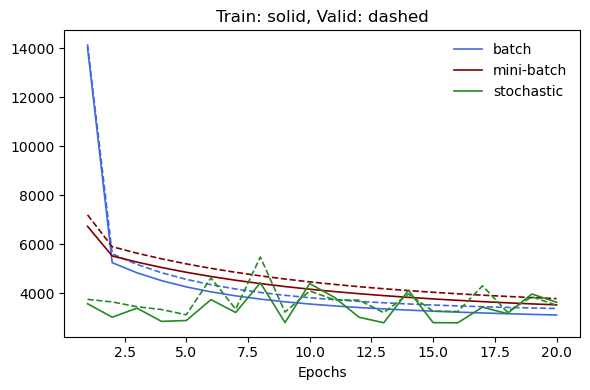

In [48]:
losses = {
    "batch": losses_bgd,
    "mini-batch": losses_mbgd,
    "stochastic": losses_sgd,
}
plot_loss(losses)